In [1]:
from scipy.interpolate import interp1d
import numpy as np
from matplotlib import pyplot as plt
import tensorboard as tb
import tensorflow.compat.v1 as tf
from typing import List
tf.disable_v2_behavior()
import os
from glob import glob

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
path_baseline_DQN = 'colab_DQN_infinite_horizon_JBW-v2'
path_baseline_PPO = 'colab_PPO_infinite_horizon_JBW-v2'
path_baseline_A2C = 'colab_A2C_infinite_horizon_JBW-v2'
path_DQN = 'colab_DQN_infinite_horizon_JBW-v1'
path_PPO = 'colab_PPO_infinite_horizon_JBW-continuous-1e5-v4'
path_A2C = 'colab_A2C_infinite_horizon_JBW-v1'

TAG = 'rollout/ep_rew_mean'

# legend_labels = ["DQN Baseline","PPO Baseline","A2C Baseline","DQN","PPO","A2C"]
# legend_labels = ["DQN Exp 1","PPO Exp 1","A2C Exp 1","DQN Exp 2","PPO Exp 2","A2C Exp 2"]

# legend_labels = ["DQN","PPO","A2C"]
# legend_labels = [str(i) for i in list((range(6)))]
# legend_labels = ["PPO Baseline","DQN","PPO","A2C"]

In [3]:
files_baseline_DQN = [y for x in os.walk(path_baseline_DQN) for y in glob(os.path.join(x[0], '*'))]
files_baseline_PPO = [y for x in os.walk(path_baseline_PPO) for y in glob(os.path.join(x[0], '*'))]
files_baseline_A2C = [y for x in os.walk(path_baseline_A2C) for y in glob(os.path.join(x[0], '*'))]
files_DQN = [y for x in os.walk(path_DQN) for y in glob(os.path.join(x[0], '*'))]
files_PPO = [y for x in os.walk(path_PPO) for y in glob(os.path.join(x[0], '*'))]
files_A2C = [y for x in os.walk(path_A2C) for y in glob(os.path.join(x[0], '*'))]

In [4]:
files_baseline_DQN = [x for x in files_baseline_DQN if 'tfevents' in x]
files_baseline_PPO = [x for x in files_baseline_PPO if 'tfevents' in x]
files_baseline_A2C = [x for x in files_baseline_A2C if 'tfevents' in x]
files_DQN = [x for x in files_DQN if 'tfevents' in x]
files_PPO = [x for x in files_PPO if 'tfevents' in x]
files_A2C = [x for x in files_A2C if 'tfevents' in x]

# experiments = [files_baseline_DQN, files_baseline_PPO, files_baseline_A2C, files_DQN, files_PPO, files_A2C]

experiments = [files_DQN, files_PPO, files_A2C]
# experiments = [files_baseline_PPO, files_DQN, files_PPO, files_A2C]

In [5]:
ys = []

i = 0
for paths in experiments:
    print('experiment',i)
    ys.append([])
    j = 0
    for path in paths:
        ys[i].append([])
        print('seed',j)
        for e in tf.compat.v1.train.summary_iterator(path):
            for v in e.summary.value:
                if v.tag == TAG:
        #             print(v.simple_value)
                    ys[i][j] = ys[i][j] + [v.simple_value]
        j = j+1
    i = i+1

# print(ys[0][0])

experiment 0
seed 0
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
seed 1
seed 2
seed 3
seed 4
experiment 1
seed 0
seed 1
seed 2
seed 3
seed 4
experiment 2
seed 0
seed 1
seed 2
seed 3
seed 4
seed 5
seed 6


In [6]:
print('before filtering:')
for exp in ys:
    print([len(i) for i in exp])
print()

for exp in ys:
    m = max([len(i) for i in exp])
    print(m)
    i = 0
    for seed in exp:
        if len(seed) < m:
            exp.pop(i)
            i -= 1
        i += 1
        
print('after filtering:')
for exp in ys:
    print([len(i) for i in exp])

before filtering:
[100, 100, 100, 100, 100]
[977, 977, 977, 977, 977]
[2000, 2000, 2000, 2000, 2000, 2000, 2000]

100
977
2000
after filtering:
[100, 100, 100, 100, 100]
[977, 977, 977, 977, 977]
[2000, 2000, 2000, 2000, 2000, 2000, 2000]


In [7]:
def smooth(scalars: List[float], weight: float) -> List[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return smoothed

In [8]:
# ys = [experiments, seeds, values] - use this to find largest nested sub array:
x = [[len(j) for j in i] for i in ys]
max_len = max(max(x))
print(max_len)

2000


In [9]:
for i in range(len(ys)):
    for j in range(len(ys[i])):
        ys[i][j] = smooth(ys[i][j], 0.95)

In [10]:
i = 0
for exp in ys:
    j = 0
    for y in exp:
        if len(y) == max_len:
            continue
        x = list(range(len(y)))
#         print(len(x))
        f = interp1d(x, y)
        f2 = interp1d(x, y, kind='cubic')

        xnew = np.linspace(0, len(y)-1, num=max_len, endpoint=True)
#         print(len(f(xnew)))

        ys[i][j] = f(xnew)
        j = j + 1
    i = i + 1

[0, 200000, 400000, 600000, 800000, 1000000]


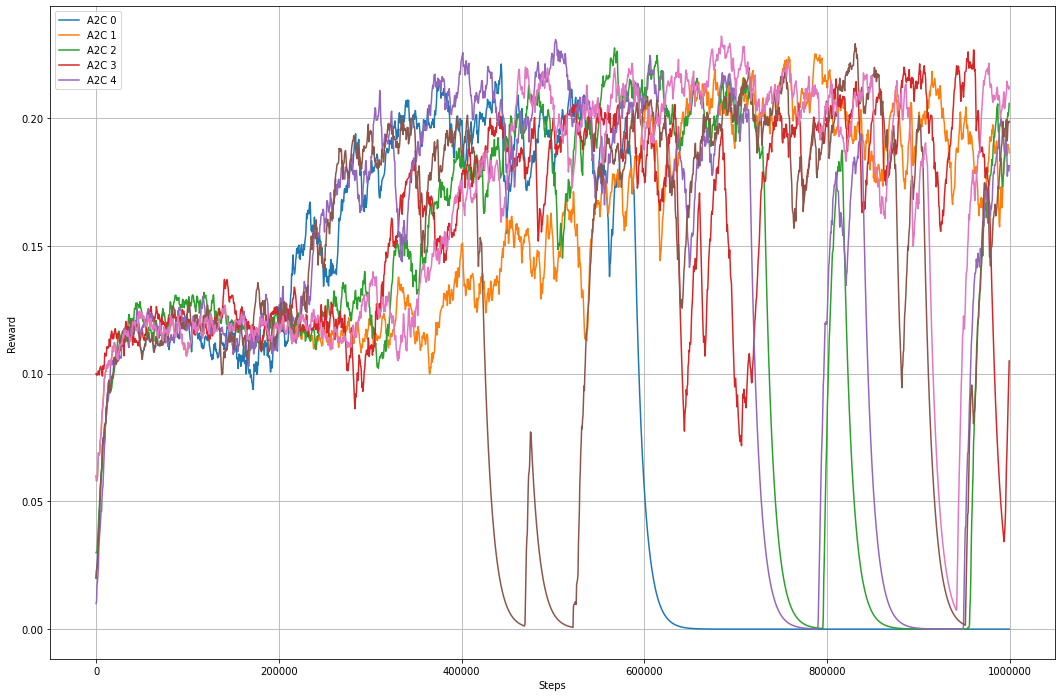

In [17]:
plt.figure(figsize=(18,12))
    
x = list(range(max_len))
i=1
for y in ys[2]:
    plt.plot(x, y)
    i = i + 1
# plt.plot(ys[1][3])
    
legend_labels = [("A2C "+str(i)) for i in list((range(len(ys[1]))))]
# legend_labels = ["PPO"]
plt.legend(legend_labels, loc='upper left')
ticks = x[0::len(x)//5]
ticks.append(len(x))
labels = [(1000000//len(x)) * i for i in ticks]
plt.xticks(ticks=ticks, labels=labels)
plt.ylabel('Reward')
plt.xlabel('Steps')
print(labels)
plt.grid()
plt.show()